## Alt-Clinic (COVID-19 data)

Please continue reading if you (alternatively) would like to work with the recent COVID-19 data. The data (per country) are provided **daily** via this GitHub repository https://github.com/CSSEGISandData/COVID-19.

You are going to follow a similar approach as above, but adapted using the following steps:

- [x] Start by exploring the plot of the COVID-19 cases (in total) and justify the exponential rate of increase
- [ ] Proper visualizations of the timeseries

Obviously, one interesting task is to compare how new infection cases appear in different countries and if there is a similarity in the evolution of these timeseries, i.e. can we assume that the timeseries evolution of infections in the Netherlands will have the same evolution as in e.g. China or Italy?

- [ ] Provide commentary on the problems that arise from the selection bias introduced by different ways that countries handle reporting. If you find fit, do some research into how countries do tests and how do they report their cases
- [ ] Provide commentary (and eventually a solution) of the "start day problem" of the timeseries: The problem is that while in China the outbreak was already in January, in Italy it was in late February and in the Netherlands is not quite yet determined(?). Define your "day 0" properly: If you look online, some people consider as day 0, either the day that the country reported the first infection, or the day that a cummulative amount of e.g. 50 infections were reported, or you might think of something else. The reason for this is to have a proper comparison metric for the timeseries of different countries.
* Pick some countries (incl. Netherlands) and visualize the results on this "shifted"/"normalized" time-scale
* Report preliminary results on the visual inspection of the plots

And now for the most challenging task, let's try to predict! The real challenge here is that we don't have enough data points for having accurate train/test models, so you have to think of a work-around (e.g. fit model for a deep-in-the-outbreak-country like China and then try to see how that model performs on other countries).

Here are some steps to follow:

* Try to fit an ARIMA model for predicting the evolution of the infected cases worldwide
* Try to fit an ARIMA model for a specific country (e.g. China).
* Use this guide (http://people.duke.edu/~rnau/arimrule.htm) as indicative rules for which model fits the best
* As the situation evolves and since the clinic is delivered in one week, you can use "real" world data for testing! Make sure to download the data every day and check your model prediction.
* Show your predictions in a plot
* Evaluate your models using MAE, MSE and R-squared

Since this is "extra-ordinary" conditions, let me(us) know how we can help you more into this or if you have any other cool idea. 

Stay healthy and enjoy!

### Ideas
* stationarize?
* correlogram


In [64]:
import IPython.core.display
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (18, 6)
matplotlib.rcParams['lines.linewidth'] = 1
sns.set(style="ticks")
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [65]:
path = "data/time_series_19-covid-"
confirmed = pd.read_csv(path+"Confirmed.csv",keep_default_na=False)
deaths = pd.read_csv(path+"Deaths.csv",keep_default_na=False)
recovered = pd.read_csv(path+"Recovered.csv",keep_default_na=False)

In [66]:
dfs = [confirmed, deaths,recovered]

In [67]:
colors = ['y','r','g']

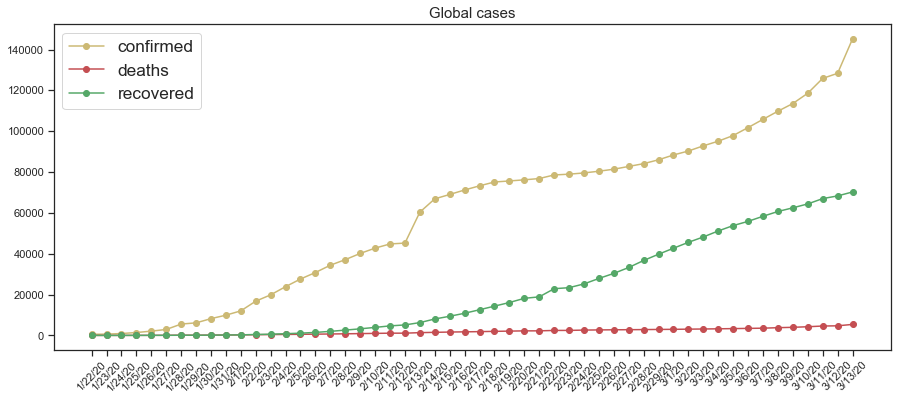

In [68]:
plt.figure(figsize=(15, 6))
for i,df in enumerate(dfs):
    total_cases = df.iloc[:,4:].sum()
    plt.plot(total_cases.index,total_cases.values,'-o'+colors[i])
plt.xticks(rotation=45)
plt.legend(labels=['confirmed','deaths','recovered'],loc='upper left',fontsize='x-large')
plt.title('Global cases',fontsize=15)
plt.show()

From [Wikipedia](https://en.wikipedia.org/wiki/Exponential_growth) (aka The Most Reliable and Academic Source Possible &trade;): "Exponential growth is a specific way that a quantity may increase over time. It occurs when the instantaneous rate of change (that is, the derivative) of a quantity with respect to time is proportional to the quantity itself."

Furthermore, as presented by [3Blue1Brown](https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be), we can model the rate of change of covid-19 cases in the following manner:
#### $\Delta N_d = E \cdot p \cdot N_d$
where:
* $N_d$ - number of cases on a given day
* $E$ - avg. number of people that are exposed to an infected person each day
* $p$ - probability of each exposure becoming an infection

In plain English:
* the more people are in contact with infected people, the faster the number of cases increases (this is why social distancing is so important)
* the higher the probability of an exposure becoming an infection, the faster the number of cases increases (this why taking prevention measures, such as washing hands more often, is so important)
* and finally, the higher the number of cases, the faster the number of cases increases ($\Delta N_d$ is proportional to $N_d$)

The last bullet point proves that we are dealing with an exponential growth (by definition).

## Comparison of the virus spread between countries

In [69]:
confirmed_per_country = confirmed.groupby(by='Country/Region').sum().drop(['Lat', 'Long'], 1)

In [70]:
current_confirmed = confirmed_per_country['3/13/20']

https://stackoverflow.com/questions/56757092/find-first-and-last-non-zero-column-in-each-row-of-a-pandas-dataframe

In [71]:
start_date = confirmed_per_country.mask(confirmed_per_country < 10).apply(pd.Series.first_valid_index, 1).dropna()

In [72]:
dates = list(confirmed.columns[4:])

In [73]:
normalized = pd.DataFrame(index=start_date.index, columns=confirmed_per_country.columns)

In [74]:
for country in start_date.index:
    lag = dates.index(start_date[country])
    shifted = pd.Series(confirmed_per_country.loc[country].to_frame().shift(periods=-lag).values.flatten(),index=confirmed_per_country.loc[country].index)
    normalized.loc[country,:] = shifted
normalized.columns = range(len(normalized.columns))

In [91]:
df = pd.DataFrame({'Col1': [10, 20, 15, 30, 45],
                   'Col2': [13, 23, 18, 33, 48],
                   'Col3': [17, 27, 22, 37, 52]})

In [92]:
df

,Col1,Col2,Col3
0,10,13,17
1,20,23,27
2,15,18,22
3,30,33,37
4,45,48,52


In [93]:
df.loc[0] = df.shift(periods=1).loc[0]

In [94]:
df

,Col1,Col2,Col3
0,NaN,NaN,NaN
1,20.0,23.0,27.0
2,15.0,18.0,22.0
3,30.0,33.0,37.0
4,45.0,48.0,52.0


In [90]:
normalized.loc['China']

0       548
1       643
2       920
3      1406
4      2075
5      2877
6      5509
7      6087
8      8141
9      9802
10    11891
11    16630
12    19716
13    23707
14    27440
15    30587
16    34110
17    36814
18    39829
19    42354
20    44386
21    44759
22    59895
23    66358
24    68413
25    70513
26    72434
27    74211
28    74619
29    75077
30    75550
31    77001
32    77022
33    77241
34    77754
35    78166
36    78600
37    78928
38    79356
39    79932
40    80136
41    80261
42    80386
43    80537
44    80690
45    80770
46    80823
47    80860
48    80887
49    80921
50    80932
51    80945
Name: China, dtype: object

In [89]:
normalized.mean()

0        20.475000
1        26.698630
2        38.132353
3        59.852459
4        84.785714
5       115.872727
6       194.702128
7       235.914894
8       338.048780
9       440.473684
10      604.090909
11      901.034483
12     1092.241379
13     1489.320000
14     1934.095238
15     2202.285714
16     2626.285714
17     2753.600000
18     3339.444444
19     4060.687500
20     4261.812500
21     5010.533333
22     4733.923077
23     5250.846154
24     5430.923077
25     5612.846154
26     5791.769231
27     5993.000000
28     6099.000000
29     6217.076923
30     6312.307692
31     6530.307692
32     6659.461538
33     6737.384615
34     6943.461538
35     7322.833333
36     8062.363636
37     8991.100000
38     9145.400000
39    10287.555556
40    11566.625000
41    12749.428571
42    14880.833333
43    20374.250000
44    40380.000000
45    40422.500000
46    80823.000000
47    80860.000000
48    80887.000000
49    80921.000000
50    80932.000000
51    80945.000000
dtype: float

In [76]:
current_confirmed.sort_values(ascending=False)

Country/Region
China                     80945
Italy                     17660
Iran                      11364
Korea, South               7979
Spain                      5232
Germany                    3675
France                     3667
US                         2179
Switzerland                1139
Norway                      996
Sweden                      814
Netherlands                 804
Denmark                     804
United Kingdom              801
Japan                       701
Cruise Ship                 696
Belgium                     559
Austria                     504
Qatar                       320
Singapore                   200
Australia                   200
Malaysia                    197
Canada                      193
Greece                      190
Bahrain                     189
Israel                      161
Finland                     155
Brazil                      151
Czechia                     141
Slovenia                    141
Iceland                  

In [84]:
import plotly.graph_objects as go
fig = go.Figure()
countries = normalized.index

for country in countries:
    df = normalized.loc[country]
    fig.add_trace(go.Scatter(x=df.index, y=df.values,mode='lines',name=country))
    
fig.update_layout(title={
    'text': 'Global cases',
    'x':0.5})
fig.show()

In [ ]:
country = 'China'
shifted = pd.Series(confirmed_per_country.loc[country].to_frame().shift(periods=-lag).values.flatten(),index=confirmed_per_country.loc[country].index)
normalized.loc[country,:] = shifted

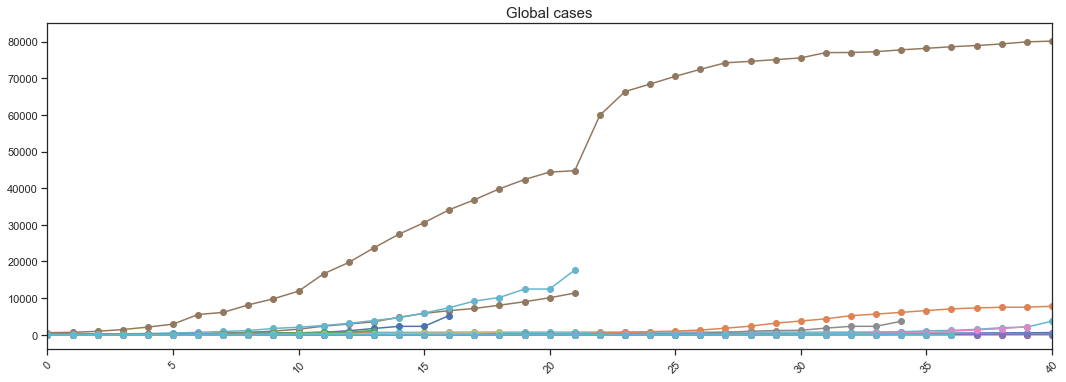

In [79]:
# plt.figure(figsize=(15, 10
countries = normalized.index
for i in countries:
    df = normalized.loc[i]
    plt.plot(df.index,df.values,'-o')
plt.xticks(rotation=45)
plt.xlim(0,40)
# plt.legend(labels=countries,loc='upper left',fontsize='small')
plt.title('Global cases',fontsize=15)
plt.show()

In [38]:
i = confirmed_per_country.index[0]
df = confirmed_per_country.loc[i]